In [7]:
import pandas as pd
import numpy as np

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor

In [198]:
final_daily = pd.read_csv('dash_app/data/resampled/final_daily.csv')
# final_daily['Datetime'] = pd.to_datetime(final_daily.loc[:,'Datetime'], infer_datetime_format=True)
# final_daily = final_daily.set_index('Datetime')
final_daily = final_daily.drop('Datetime', axis = 1)

In [199]:
lag_cols = final_daily.columns
LAG = 5
for i in range(1, LAG):
    for col in lag_cols:
        final_daily[col + '__' + str(i)] = final_daily[col].shift(i)
#         print(df_lag.shape)

In [200]:
final_daily = final_daily.fillna(final_daily.mean)

In [174]:
def split_data(data):
    train, test = data[4:data.shape[0] - 210], data[data.shape[0] - 210:data.shape[0]]
    train = array(split(train, int(len(train)/7)))
    test = array(split(test, int(len(test)/7)))
    return train, test

In [175]:
# def eval_forecast(actual, predicted):
#     scores = []
#     for i in range(actual.shape[1]):
#         mse = mean_squared_error(actual[:, i], predicted[:, i])
#         rmse = sqrt(mse)
#         scores.append(rmse)
#     s = 0
#     for row in range(actual.shape[0]):
#         for col in range(actual.shape[1]):
#             s += (actual[row, col] - predicted[row, col])**2
#     score = sqrt(s / (actual.shape[0] * actual.shape[1]))
#     return score, scores

In [143]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        rmse = sqrt(mse)
        scores.append(rmse)
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [144]:
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [157]:
def get_models(models=dict()):
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    models['en'] = ElasticNet()
    models['huber'] = HuberRegressor()
    models['lars'] = Lars()
    models['llars'] = LassoLars()
#     models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
    models['ranscac'] = RANSACRegressor()
#     models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
    return models

In [158]:
def make_pipeline(model):
    steps = list()
#     steps.append(('standardize', StandardScaler()))
#     steps.append(('normalize', MinMaxScaler()))
    steps.append(('model', model))
    pipeline = Pipeline(steps=steps)
    return pipeline

In [159]:
def forecast(model, input_x, n_input):
    yhat_sequence = list()
    input_data = [x for x in input_x]
    for j in range(7):
        X = array(input_data[-n_input:]).reshape(1, n_input)
        yhat = model.predict(X)[0]
        yhat_sequence.append(yhat)
        input_data.append(yhat)
#     print(len(yhat_sequence))
    return yhat_sequence

In [160]:
def to_series(data):
    series = [week[:, 0] for week in data]
    series = array(series).flatten()
    return series

In [161]:
def to_supervised(history, n_input):
    data = to_series(history)
    X, y = list(), list()
    ix_start = 0
    for i in range(len(data)):
        ix_end = ix_start + n_input
        if ix_end < len(data):
            X.append(data[ix_start:ix_end])
            y.append(data[ix_end])
        ix_start += 1
    return array(X), array(y)

In [162]:
def sklearn_predict(model, history, n_input):
    train_x, train_y = to_supervised(history, n_input)
    pipeline = make_pipeline(model)
    pipeline.fit(train_x, train_y)
    yhat_sequence = forecast(pipeline, train_x[-1, :], n_input)
    return yhat_sequence

In [163]:
def evaluate_model(model, train, test, n_input):
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        yhat_sequence = sklearn_predict(model, history, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i, :])
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [201]:
train, test = split_data(final_daily.values)

In [202]:
models = get_models()

In [203]:
n_input = 7

In [204]:
days = range(0,7)

lr: [5.018] 5.7, 5.4, 4.3, 4.5, 5.3, 5.2, 4.6
lasso: [5.004] 5.7, 5.3, 4.3, 4.5, 5.3, 5.1, 4.6
ridge: [5.018] 5.7, 5.4, 4.3, 4.5, 5.3, 5.2, 4.6
en: [5.006] 5.6, 5.3, 4.3, 4.5, 5.3, 5.2, 4.6
huber: [5.067] 5.7, 5.5, 4.2, 4.4, 5.5, 5.2, 4.7
lars: [5.018] 5.7, 5.4, 4.3, 4.5, 5.3, 5.2, 4.6
llars: [6.504] 7.4, 6.3, 6.5, 6.2, 6.5, 6.3, 6.1
ranscac: [6.343] 6.3, 6.2, 5.5, 5.2, 6.7, 7.2, 7.1


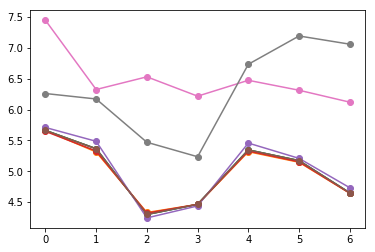

In [212]:
trains = []
tests = []
for name, model in models.items():
    trains.append(train)
    tests.append(test)
    score, scores = evaluate_model(model, train, test, n_input)
    summarize_scores(name, score, scores)
    pyplot.plot(days, scores, marker='o', label=name)

In [211]:
trains[0].shape

(121, 7, 35)

In [213]:
tests[0].shape

(30, 7, 35)